In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import seaborn as sns

In [3]:
# These two functions are for simulating two different variants (e.g., only WT and B.1.1.7), and were used to generate Fig. 1 and some of Table 1

def SIR_vaccine(t, y, params):
    # compartments: S, I, R, I' (i.e., infected with variant), R', V
    # parameters: beta (infectiousness), beta_m (infectiousness of mutant), beta_c (infectiousness of mutant to immune), beta_v (infectiousness of mutant to vaccinated), rho (recovery rate), rho_m, v (vaccination rate), w (loss of immunity rate), w_v
    S, I, R, I_mut, R_mut, V = y
    beta, beta_m, beta_c, beta_v, rho, rho_m, v, w, w_v = params
    
    #vax_rate = min(S, v)
    
    dV = v*S - (w_v + I_mut*beta_v)*V
    dS = -(beta*I + beta_m*I_mut + v)*S + w * (R + R_mut) + w_v*V
    dI = beta*S*I - rho*I
    dR = rho*I - (w + beta_c*I_mut)*R
    dI_mut = (beta_m*S + beta_c*R + beta_v*V - rho_m)*I_mut
    dR_mut = rho_m*I_mut - w*R_mut
    return(np.array([dS, dI, dR, dI_mut, dR_mut, dV]))

def simulate_evo_vaccine(init, params, t_span, mut_rate, pop_size):
    if mut_rate == 0:
        mut_emerge = np.inf
    else:
        mut_emerge = np.random.exponential(scale=1/mut_rate)
    t_return = np.arange(t_span[0], t_span[1])
    pre_mut = solve_ivp(lambda t,y: SIR_vaccine(t,y,params), t_span, init_cond, t_eval=t_return)
    new_case_numbers = total_pop_size*params[0]*pre_mut.y[0,:]*pre_mut.y[1,:]
    mut_time = None
    total_new = 0
    for i in range(len(new_case_numbers)):
        total_new += new_case_numbers[i]
        if total_new > mut_emerge:
            mut_time = t_return[i]
            new_init = pre_mut.y[:,i]
            new_init[1] -= 1/pop_size
            new_init[3] += 1/pop_size
            new_time = t_return[i:]
            pre_t = pre_mut.t[:i]
            pre_y = pre_mut.y[:,:i]
            break
    if mut_time is None:
        return((pre_mut.t, pre_mut.y))
    post_mut = solve_ivp(lambda t,y: SIR_vaccine(t,y,params), (mut_time, t_span[1]), new_init, t_eval=new_time)
    if (len(pre_t)==0):
        return((post_mut.t, post_mut.y))
    return((np.concatenate([pre_t, post_mut.t]), np.concatenate([pre_y, post_mut.y], axis=1)))

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


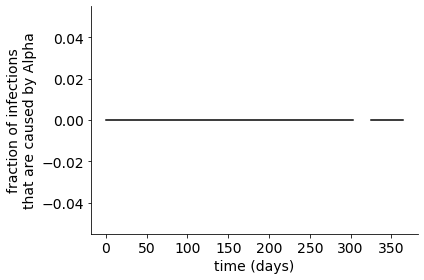

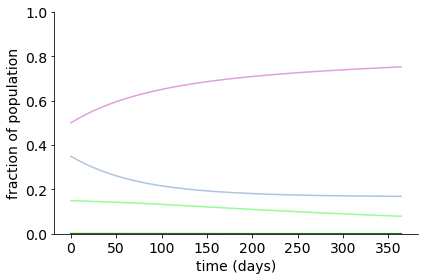

In [14]:
#Fig. 1B-C
R0_val = 3.32

# B.1.1.7 params
mutation_emerg_rate = 0 #prob per new infection of new strain appearing
total_pop_size = 3e8
trans_mut = 1.59
cross_immunity = 1 - 0.895
trans = R0_val * 0.1
mut_perc = 0.596
vac_perc = 0.5
inf_perc = 0.0013
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
params = [trans, trans_mut*trans, trans_mut*trans*cross_immunity, trans_mut*trans*cross_immunity, 0.1, 0.1, 0.01, 0.002, 0.002]

init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])
t_span = (0,365)

test = simulate_evo_vaccine(init_cond, params, t_span, mutation_emerg_rate, total_pop_size)
test = (test[0], np.maximum(test[1], 0))

plt.figure()
plt.plot(test[0], test[1][3,:]/(test[1][3,:]+test[1][1,:]), color="k")
plt.xlabel("time (days)", fontsize=14)
plt.ylabel("fraction of infections\nthat are caused by Alpha", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig("./manuscript_SHORT/figures/raw_panels/b117_dom.eps", transparent=True)
plt.show()

plt.figure()
plt.plot(test[0], test[1][0,:], label="S", color="lightsteelblue")
plt.plot(test[0], test[1][1,:], label="I", color="pink", lw=2)
plt.plot(test[0], test[1][2,:], label="R", color="palegreen")

plt.plot(test[0], test[1][4,:], label="R_mut", color="bisque")
plt.plot(test[0], test[1][5,:], label="V", color="plum")
plt.plot(test[0], test[1][3,:], label="I_mut", color="green", lw=2)
#plt.plot(test[0], np.sum(test[1], axis=0), label="all")
plt.ylim([0,1])
#plt.legend()
plt.ylabel("fraction of population", fontsize=14)
plt.xlabel("time (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

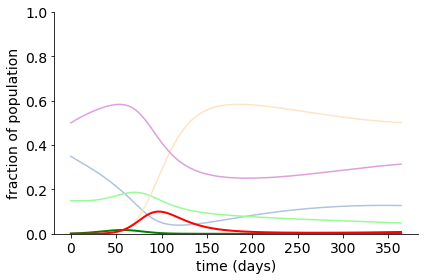

In [49]:
#Fig. 1D
R0_val = 3.32

# B.1.351 params
mutation_emerg_rate = 0 #prob per new infection of new strain appearing
total_pop_size = 3e8
trans_mut = 1.5/1.59
cross_immunity = 1 - 0.75
trans = R0_val * 0.1 *1.59

mut_perc = 0.01
vac_perc = 0.5
inf_perc = 0.0013
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
params = [trans, trans_mut*trans, trans_mut*trans*cross_immunity, trans_mut*trans*cross_immunity, 0.1, 0.1, 0.01, 0.002, 0.002]

init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])
t_span = (0,365)

test = simulate_evo_vaccine(init_cond, params, t_span, mutation_emerg_rate, total_pop_size)
test = (test[0], np.maximum(test[1], 0))

plt.figure()
plt.plot(test[0], test[1][0,:], label="S", color="lightsteelblue")
plt.plot(test[0], test[1][1,:], label="I", color="green", lw=2)
plt.plot(test[0], test[1][2,:], label="R", color="palegreen")

plt.plot(test[0], test[1][4,:], label="R_mut", color="bisque")
plt.plot(test[0], test[1][5,:], label="V", color="plum")
plt.plot(test[0], test[1][3,:], label="I_mut", color="red", lw=2)
#plt.plot(test[0], np.sum(test[1], axis=0), label="all")
plt.ylim([0,1])
#plt.legend()
plt.ylabel("fraction of population", fontsize=14)
plt.xlabel("time (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

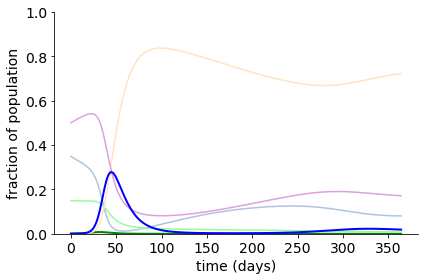

In [4]:
#Fig. 1E
R0_val = 3.32

# P.1 params
mutation_emerg_rate = 0 #prob per new infection of new strain appearing
total_pop_size = 3e8
trans_mut = 2/1.59
cross_immunity = 1 - 0.68
trans = R0_val * 0.1 * 1.59
mut_perc = .037
vac_perc = 0.5
inf_perc = 0.0013
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
params = [trans, trans_mut*trans, trans_mut*trans*cross_immunity, trans_mut*trans*cross_immunity, 0.1, 0.1, 0.01, 0.002, 0.002]

init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])
t_span = (0,365)

test = simulate_evo_vaccine(init_cond, params, t_span, mutation_emerg_rate, total_pop_size)
test = (test[0], np.maximum(test[1], 0))

plt.figure()
plt.plot(test[0], test[1][0,:], label="S", color="lightsteelblue")
plt.plot(test[0], test[1][1,:], label="I", color="green", lw=2)
plt.plot(test[0], test[1][2,:], label="R", color="palegreen")

plt.plot(test[0], test[1][4,:], label="R_mut", color="bisque")
plt.plot(test[0], test[1][5,:], label="V", color="plum")
plt.plot(test[0], test[1][3,:], label="I_mut", color="blue", lw=2)
#plt.plot(test[0], np.sum(test[1], axis=0), label="all")
plt.ylim([0,1])
#plt.legend()
plt.ylabel("fraction of population", fontsize=14)
plt.xlabel("time (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

In [15]:
# Table 1 entries
# Run after running one of the above blocks for each of the variant combinations
def total_infect_time2(y, params, total_pop_size):
    beta, beta_m, beta_c, beta_v, rho, rho_m, v, w, w_v = params
    new_WT = total_pop_size*beta*y[0,:]*y[1,:]
    new_mut_susc = (beta_m*y[0,:])*y[3,:]*total_pop_size
    new_mut_vacc = (beta_c*y[2,:] + beta_v*y[5,:])*y[3,:]*total_pop_size
    return((new_WT+new_mut_susc, new_mut_vacc))

unvacc_IFR = 0.0068
vacc_IFR = unvacc_IFR*(1-0.981)/(1-0.965)

new_inf = total_infect_time2(test[1], params, total_pop_size)
print("total number of new infections in 1 year")
print(np.sum(new_inf[0]) + np.sum(new_inf[1]))
print("total number of COVID-19 deaths in 1 year")
print(unvacc_IFR*np.sum(new_inf[0]) + np.sum(new_inf[1])*vacc_IFR)

total number of new infections in 1 year
3485278.0398829337
total number of COVID-19 deaths in 1 year
23699.89067120395


In [38]:
# These two functions are for simulating any number of variants, and were used to generate Fig. 2-3 and some of Table 1

def make_multi_SIR_eq(params):
    # compartments: S, V, Rs, Is
    # parameters: beta_matrix: S/V/R dim * num_muts, rho (recovery rate), v, w
    num_muts = np.shape(params[0])[1]
    
    def to_return(t, y):
        SVR_vect = y[:(2+num_muts)]
        inf_vect = y[(2+num_muts):]
        S = y[0]
        V = y[1]
        beta_matrix, rho, v, w = params

        new_inf = np.transpose(np.matmul(np.transpose(beta_matrix), np.reshape(SVR_vect, (2+num_muts,1)))) * inf_vect
        inf_loss = np.reshape(np.matmul(beta_matrix, np.reshape(inf_vect, (num_muts,1))),(2+num_muts,))  * SVR_vect
        
        dV = v*S - w*V - inf_loss[1]
        dS = -v*S - inf_loss[0] + w*np.sum(y[1:(2+num_muts)])
        dI = new_inf - rho*inf_vect
        dR = rho*inf_vect - inf_loss[2:] - w*y[2:(2+num_muts)]
        dY = np.concatenate([[dS], [dV], dR.tolist(), dI.tolist()[0]])
        return(dY)
    
    return(to_return)

def simulate_evo_vaccine_multi(init, params, t_span):
    t_return = np.arange(t_span[0], t_span[1])
    SIR_vaccine_fn = make_multi_SIR_eq(params)
    
    sol = solve_ivp(SIR_vaccine_fn, t_span, init_cond, t_eval=t_return)
    
    return((sol, SIR_vaccine_fn))

In [53]:
#Simulations for Fig. 2

adv_b117 = 1.59
adv_b1351 = 1.5
adv_p1 = 2

cross_b117 = 1-0.895
cross_b1351 = 1-0.75
cross_p1 = 1-.68

contact_rate = 0.332

# rows: effect on an S/V/R compartment
# cols: infected compartments (WT, B.1.1.7, B.1.351, P.1)
beta_matrix = np.array([[1, adv_b117, adv_b1351, adv_p1], 
                        [0, adv_b117*cross_b117, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, adv_b117*cross_b117, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, 0, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]])
beta_matrix = contact_rate*beta_matrix
params = [beta_matrix, 0.1, 0.01, 0.002]

init_b117 = 0.596
init_b1351 = 0.01
init_p1 = 0.037
init_WT = 1 - init_p1 - init_b1351 - init_b117

vac_perc = 0.5
inf_perc = 0.0013
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7

init_cond = [susc_perc, vac_perc]
init_cond.extend(imm_perc * np.array([init_WT, init_b117, init_b1351, init_p1]))
init_cond.extend(inf_perc * np.array([init_WT, init_b117, init_b1351, init_p1]))
init_cond = np.array(init_cond)

t_span = (0,365)

test = simulate_evo_vaccine_multi(init_cond, params, t_span)
test = test[0]

unvacc_IFR = 0.0068
vacc_IFR = unvacc_IFR*(1-0.981)/(1-0.965)

def total_infect_multi(y, beta_matrix, total_pop_size):
    num_muts = np.shape(beta_matrix)[1] 
    SVR_vect = y[:(2+num_muts),:]
    inf_vect = y[(2+num_muts):, :]
    new_inf = np.matmul(np.transpose(beta_matrix), SVR_vect) * inf_vect * total_pop_size
    return(new_inf)

def total_infect_multi2(y, beta_matrix, total_pop_size):
    num_muts = np.shape(beta_matrix)[1] 
    SVR_vect = y[:(2+num_muts),:]
    inf_vect = y[(2+num_muts):, :]
    inf_loss = np.matmul(beta_matrix, inf_vect) * SVR_vect * total_pop_size
    return(inf_loss)

total_num_inf = np.sum(total_infect_multi(test.y, beta_matrix, total_pop_size))
print("total number of new infections in 1 year")
print(total_num_inf)
print("total number of COVID-19 deaths in 1 year")
adj_fatalities = np.transpose(np.sum(total_infect_multi2(test.y, beta_matrix, total_pop_size), axis=1)) * np.array([unvacc_IFR, vacc_IFR, vacc_IFR, vacc_IFR, vacc_IFR, vacc_IFR])
print(np.sum(adj_fatalities))

total number of new infections in 1 year
373724529.0255495
total number of COVID-19 deaths in 1 year
1859506.4773577603


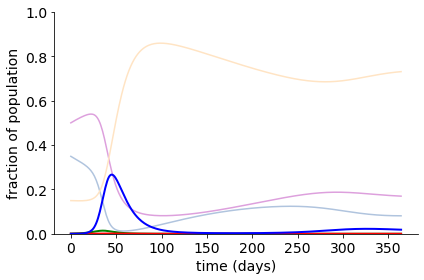

In [40]:
# Plotting Fig. 2B
plt.figure()
plt.plot(test.t, test.y[0,:], label="S", color="lightsteelblue")


plt.plot(test.t, test.y[1,:], label="V", color="plum")
plt.plot(test.t, np.sum(test.y[2:-4,:], axis=0), label="R", color="bisque")

plt.plot(test.t, test.y[-4,:], label="I WT", color="pink", lw=2)
plt.plot(test.t, test.y[-3,:], label="I B.1.1.7", color="green", lw=2)
plt.plot(test.t, test.y[-2,:], label="I B.1.351", color="red", lw=2)
plt.plot(test.t, test.y[-1,:], label="I P.1", color="blue", lw=2)
plt.ylim([0,1])
#plt.legend()
plt.ylabel("fraction of population", fontsize=14)
plt.xlabel("time (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

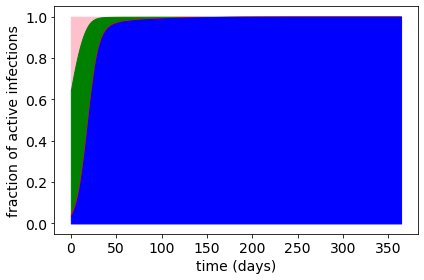

In [41]:
#Plotting Fig. 2C
infection_fractions = test.y[-4:,:]/np.sum(test.y[-4:,:], axis=0)

plt.figure()
plt.fill_between(test.t, y1=1, y2=1-infection_fractions[0,:], color="pink")
plt.fill_between(test.t, y1=1-infection_fractions[0,:], y2=1-np.sum(infection_fractions[:2,:], axis=0), color="green")
plt.fill_between(test.t, y1=1-np.sum(infection_fractions[:2,:], axis=0), y2=1-np.sum(infection_fractions[:3,:], axis=0), color="red")
plt.fill_between(test.t, y1=1-np.sum(infection_fractions[:3,:], axis=0), y2=1-np.sum(infection_fractions[:4,:], axis=0), color="blue")
plt.ylabel("fraction of active infections", fontsize=14)
plt.xlabel("time (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

In [42]:
#Simulations for Fig. 3

def total_infect_multi(y, beta_matrix, total_pop_size):
    num_muts = np.shape(beta_matrix)[1] 
    SVR_vect = y[:(2+num_muts),:]
    inf_vect = y[(2+num_muts):, :]
    new_inf = np.matmul(np.transpose(beta_matrix), SVR_vect) * inf_vect * total_pop_size
    return(new_inf)

def time_to_cumul_mut_multi(t, y, mut_idx, cutoff):
    mut_num = y[mut_idx,:]
    for i in range(len(t)):
        if mut_num[i] > cutoff:
            return(t[i])
    return(None)

total_pop_size = 3e8
beta_sweep = np.arange(0.1, 0.6, 0.01)
beta_orig = np.array([[1, adv_b117, adv_b1351, adv_p1], 
                        [0, adv_b117*cross_b117, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, adv_b117*cross_b117, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, 0, adv_b1351*cross_b1351, adv_p1*cross_p1],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]])
t_span = (0,365)
inf_data = []
time_data = []
for contact_rate in beta_sweep:
    beta_matrix = contact_rate*np.copy(beta_orig)
    params = [beta_matrix, 0.1, 0.01, 0.002]
    test = simulate_evo_vaccine_multi(init_cond, params, t_span)
    test = test[0]
    inf_data.append(total_infect_multi(test.y, beta_matrix, total_pop_size))
    time_data.append(time_to_cumul_mut_multi(test.t, np.cumsum(total_infect_multi(test.y, beta_matrix, total_pop_size), axis=1), 3, 5e6))
    

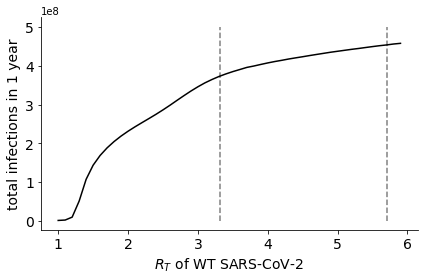

In [43]:
# Plotting Fig. 3A
totals = [np.sum(x) for x in inf_data]

plt.figure()
plt.plot(beta_sweep*10, totals, color="k")
plt.vlines([3.32,5.7], ymin=0, ymax=5e8, linestyles="dashed", color="grey")
plt.xlabel("$R_T$ of WT SARS-CoV-2", fontsize=14)
plt.ylabel("total infections in 1 year", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

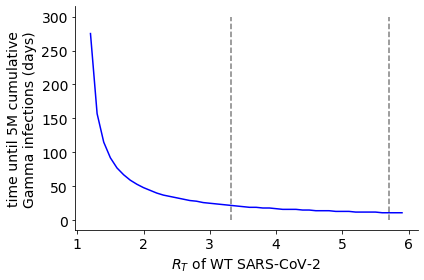

In [45]:
# Plotting Fig. 3B
plt.figure()
plt.plot(beta_sweep*10, time_data, color="blue")
plt.vlines([3.32,5.7], ymin=0, ymax=300, linestyles="dashed", color="grey")
plt.xlabel("$R_T$ of WT SARS-CoV-2", fontsize=14)
plt.ylabel("time until 5M cumulative\nGamma infections (days)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

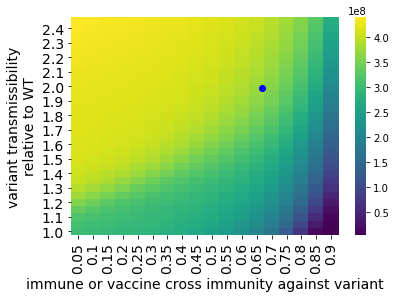

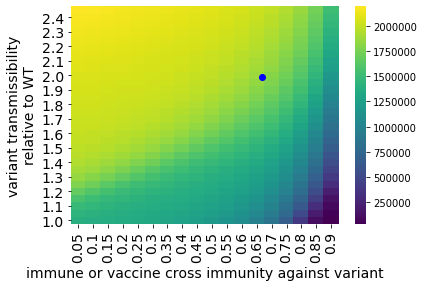

In [13]:
# Figure 4- parameter sweeps

mut_perc = 0.1
vac_perc = 0.5
inf_perc = 0.0013
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])
R0_val = 3.32
trans = R0_val * 0.1

mut_inf_sweep = np.arange(1,2.5,step=0.05)
immune_protect_sweep = np.arange(0.1, 1, step=0.05)
sweep_params = [np.nan, np.nan, np.nan, np.nan, 0.1, 0.1, 0.01, 0.002, 0.002]

mutation_emerg_rate = 0 #prob per new infection of new strain appearing
total_pop_size = 3e8
t_span = (0,365)
totals = []
deaths = []
beta_ms = []
beta_vs = []
beta = trans
for beta_m in mut_inf_sweep:
    for beta_v in immune_protect_sweep:
        new_params = sweep_params[:]
        new_params[0] = beta
        new_params[1] = beta * beta_m
        new_params[2] = beta * beta_v * beta_m
        new_params[3] = beta * beta_v * beta_m
        res = simulate_evo_vaccine(init_cond, new_params, t_span, mutation_emerg_rate, total_pop_size)
        res = (res[0], np.maximum(res[1], 0))
        num_inf = total_infect_time2(res[1], new_params, total_pop_size)
        totals.append(np.sum(num_inf[0])+np.sum(num_inf[1]))
        deaths.append(unvacc_IFR*np.sum(num_inf[0]) + np.sum(num_inf[1])*vacc_IFR)
        #time_muts.append(time_to_mut_num(res[0], res[1], new_params, 10000, total_pop_size))
        beta_ms.append(beta_m)
        beta_vs.append(1-beta_v)
        
to_plot = pd.DataFrame({"beta_m": beta_ms, "beta_v": beta_vs, "total":totals, "death":deaths})
total_heat = pd.pivot_table(to_plot, index="beta_m", columns="beta_v", values="total")
total_heat.index = [round(i,2) for i in total_heat.index]
total_heat.columns = [round(i,2) for i in total_heat.columns]

def convert_coords(x,y):
    num_x = len(total_heat.columns)
    num_y = len(total_heat.index)
    x_scale = num_x/(total_heat.columns[-1] - total_heat.columns[0])
    y_scale = num_y/(total_heat.index[-1] - total_heat.index[0])
    return(((x-total_heat.columns[0])*x_scale-0.5, (y-total_heat.index[0])*y_scale-0.5))


plt.figure()
sns.heatmap(total_heat, cmap="viridis")
plt.gca().invert_yaxis()
b1531 = convert_coords(.75, 1.5)
#plt.scatter(x=b1531[0], y=b1531[1], color="red")
b117 = convert_coords(0.895, 1.59)
#plt.scatter(x=b117[0], y=b117[1], color="magenta")
p1 = convert_coords(0.68, 2)
plt.scatter(x=p1[0], y=p1[1], color="blue")
plt.xlabel("immune or vaccine cross immunity against variant", fontsize=14)
plt.ylabel("variant transmissibility\nrelative to WT", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.tight_layout()
#plt.savefig(..., transparent=True, bbox_inches="tight")
plt.show()

#to_plot = pd.DataFrame({"beta_m": beta_ms, "beta_v": beta_vs, "total":totals, "death":deaths})
total_heat = pd.pivot_table(to_plot, index="beta_m", columns="beta_v", values="death")
total_heat.index = [round(i,2) for i in total_heat.index]
total_heat.columns = [round(i,2) for i in total_heat.columns]

plt.figure()
sns.heatmap(total_heat, cmap="viridis")
plt.gca().invert_yaxis()
b1531 = convert_coords(.75, 1.5)
#plt.scatter(x=b1531[0], y=b1531[1], color="red")
b117 = convert_coords(0.895, 1.59)
#plt.scatter(x=b117[0], y=b117[1], color="magenta")
p1 = convert_coords(0.68, 2)
plt.scatter(x=p1[0], y=p1[1], color="blue")
plt.xlabel("immune or vaccine cross immunity against variant", fontsize=14)
plt.ylabel("variant transmissibility\nrelative to WT", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.tight_layout()
#plt.savefig(..., transparent=True, bbox_inches="tight")
plt.show()